In [1]:
import numpy as np
import pandas as pd
# setting the seed allows for reproducible results
import backtrader as bt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from pypfopt import HRPOpt
from pypfopt import EfficientSemivariance
from pandas_datareader import data as pdr
from datetime import datetime
from scipy.special import softmax

#--------------

#-------------

import plotly.graph_objects as go

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

np.random.seed(123)
%matplotlib inline

very_small_float = 1.0#0.000000001

In [2]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from bt_testcode import plotPortfolioReturns, get_portfolio_values

# Model definition

In [3]:
from scipy import optimize 

def MaximizeSharpeRatioOptmzn(MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
    
    # define maximization of Sharpe Ratio using principle of duality
    def  f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
        funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
        funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
        func = -(funcNumer / funcDenomr)
        #print(func)
        return func

    #define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    
    #define bounds and other parameters
    xinit=np.repeat(0.33, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])
    
    #print('xinit',xinit.shape)
    #invoke minimize solver
    opt = optimize.minimize (f, x0 = xinit, args = (MeanReturns, CovarReturns,\
                             RiskFreeRate, PortfolioSize), method = 'SLSQP',  \
                             bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt

def get_weight(data, meanReturns, covReturns):
    
    #set portfolio size
    portfolioSize = data.shape[1]

    #set risk free asset rate of return
    Rf=0  #  average risk  free rate of return in USA 
    annRiskFreeRate = Rf/100

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + annRiskFreeRate),  (1.0 / 360.0)) - 1.0) * 100 
    #print('\nRisk free rate (daily %): ', end="")
    #print ("{0:.3f}".format(r0)) 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)

        
    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*252) 
    annRet = 252*np.array(expReturn) 
    maxSharpeRatio = (annRet-Rf)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)

    return (xOptimalArray.T).flatten()

In [68]:
class Model:
    def __init__(self):
        self.data = None
        self.isFirst = True
    
    def getModel():
        return None
    
    def resetModel():
        self.data = None
        self.isFirst = True
        pass

    # a nonconvex objective from  Kolm et al (2014)
    def deviation_risk_parity(self, w, cov_matrix):
        diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
        return (diff ** 2).sum().sum()


    #def get_allocations(self, data, model_n = 'MeanVariance', isEmsRet = False, isExpCov = False, isCleanWeight = False, upd_period = 0):
    def get_allocations(self, data, **param):

        data = pd.DataFrame(data)

        model_n = param['model_n']
        isEmsRet = param['isEmsRet']
        isExpCov = param['isExpCov']
        isCleanWeight = param['isCleanWeight']
        upd_period = param['upd_period']
        isDataCollecting = param['collectData']

        


        #data = data.fillna(0.0)
        if(self.isFirst == True) or (upd_period == 0) or (isDataCollecting==False):
            self.isFirst = False
            self.data = data.copy()
        else:
            self.data = self.data.append(data.iloc[-upd_period:])

       # print(data.iloc[-upd_period:])

        mu = expected_returns.mean_historical_return(self.data).fillna(0.0).values
        if isEmsRet == True:
            mu = expected_returns.ema_historical_return(self.data).fillna(0.0).values
    
        S = risk_models.sample_cov(self.data).fillna(0.0).values
        if isExpCov == True:    
            S = risk_models.exp_cov(self.data).fillna(0.0).values
        
        if model_n == 'CLA':
            ef = CLA(mu, S)
            weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            #hrp.portfolio_performance(verbose=True)
            if isCleanWeight == True:
                return pd.DataFrame(cleaned_weights, index=[0]).to_numpy()[0]
            return pd.DataFrame(weights, index=[0]).to_numpy()[0]

        elif model_n == 'HRP_':
            hrp = HRPOpt(self.data.pct_change())
            weights = hrp.optimize()
            cleaned_weights = hrp.clean_weights()        
            if isCleanWeight == True:
                return pd.DataFrame(cleaned_weights, index=[0]).to_numpy()[0]
            return pd.DataFrame(weights, index=[0]).to_numpy()[0]

        elif model_n == 'HRP':
            hrp = HRPOpt(self.data.pct_change(),S)
            weights = hrp.optimize()
            cleaned_weights = hrp.clean_weights()        
            if isCleanWeight == True:
                return pd.DataFrame(cleaned_weights, index=[0]).to_numpy()[0]
            return pd.DataFrame(weights, index=[0]).to_numpy()[0]


        elif model_n == 'nonconvex':
            ef = EfficientFrontier(mu, S)
            weights = ef.nonconvex_objective(self.deviation_risk_parity, ef.cov_matrix)
            cleaned_weights = ef.clean_weights()        
            if isCleanWeight == True:
                return pd.DataFrame(cleaned_weights, index=[0]).to_numpy()[0]
            return pd.DataFrame(weights, index=[0]).to_numpy()[0]

        elif model_n == 'random':
            a = np.random.uniform(size=[self.data.shape[1]])
            return softmax(a)
        elif model_n == 'equal_weight':
            a = np.array([1/self.data.shape[1]]*self.data.shape[1])
            return a
        else:
           # print('DEFAULT MODEL!')
            return get_weight(self.data, mu, S)

        return []

In [22]:
ticker = ['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY']
history_range = {'start': datetime(2008, 1, 1), 
                 'end': datetime(2020, 10, 1)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

In [23]:
stock_close = stock.iloc[:125]['Close'].reset_index(drop=True)
stock_close.head()

Symbols,MSFT,AMD,C,BA,AMZN,AAPL,MO,AEE,AIG,WY
0,35.220001,7.14,289.200012,86.620003,96.250000,6.958571,74.930000,53.349998,1126.0,71.519997
1,35.369999,6.77,289.299988,86.980003,95.209999,6.961786,75.389999,53.310001,1129.0,72.199997
2,34.380001,6.25,282.399994,85.820000,88.790001,6.430357,74.900002,52.919998,1106.0,68.620003
3,34.610001,6.08,282.600006,82.870003,88.820000,6.344286,77.230003,53.610001,1126.0,68.129997
4,33.450001,6.00,271.399994,79.910004,87.879997,6.116071,78.320000,53.310001,1111.0,66.699997


In [24]:
param={}
param ={'model_params':
    {'model_n':'equal_weight',
    'collectData':False,
    'isEmsRet':False,
    'isExpCov':False,
    'isCleanWeight':False,
    'upd_period': 0}}

In [25]:
m = Model()
m.get_allocations(stock_close, **param['model_params'])

array([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
       0.1000, 0.1000])

In [26]:

n = [0, 200, 250, 300, 350, 400, 500, 700, 1000, 1300]
def getReturnFromAlloc(n, model_n):
    r_list = []
    param={}
    param ={'model_params':
        {'model_n':model_n,
        'collectData':False,
        'isEmsRet':True,
        'isExpCov':True,
        'isCleanWeight':False,
        'upd_period': 0}}
    #print('ret, std, sharp')
    for i in n:
        stock_close = stock.iloc[i:i+125]['Close'].reset_index(drop=True).fillna(very_small_float)
        m = Model()
        alloc = m.get_allocations(stock_close.values, **param['model_params'])
        r_list.append((get_portfolio_values(alloc, stock_close)))
        #print(r_list[-1])
    return r_list

rl = getReturnFromAlloc(n, 'CLA')
for r, s, sp in rl:
    print("{:.4f}  {:.4f}  {:.4f}".format(r,s,sp))

-0.1008  0.0284  -0.0286
0.4995  0.0461  0.0874
0.5374  0.0252  0.1717
2.2204  0.1202  0.1490
0.5159  0.0148  0.2807
0.5854  0.0253  0.1868
0.2691  0.0192  0.1131
0.2804  0.0119  0.1894
0.2606  0.0095  0.2223
0.2643  0.0111  0.1918


In [27]:
model_List = ['MeanVariance', 'CLA', 'HRP', 'nonconvex', 'random', 'equal_weight']
res = {}
for mn in model_List:
    rl = getReturnFromAlloc(n, mn)
    sharp = []
    for r,s,sp in rl:
        sharp.append(sp)
    res[mn] = sharp
pd.DataFrame(res).to_csv('models_alloc_results.csv')
pd.DataFrame(res)

,MeanVariance,CLA,HRP,nonconvex,random,equal_weight
0,-0.028610,-0.028610,-0.162739,-0.170756,-0.166912,-0.162590
1,0.086879,0.087384,-0.009082,-0.006873,-0.009311,-0.013846
2,0.171619,0.171727,0.083163,0.078864,0.060870,0.056943
3,0.149012,0.149017,0.196630,0.192812,0.155334,0.165796
4,0.280505,0.280702,0.217433,0.193022,0.153772,0.149917
5,0.187186,0.186818,0.134990,0.133856,0.114366,0.119300
6,0.113157,0.113138,-0.024069,-0.004031,-0.002242,0.007581
7,0.189438,0.189439,0.089194,0.082286,0.093327,0.081492
8,0.222154,0.222276,0.155089,0.155927,0.146098,0.141798
9,0.191497,0.191805,0.091260,0.099046,0.109117,0.101611


In [28]:
ticker = ['SPY', 'TLT', 'GLD', 'RWO']
history_range = {'start': datetime(2010, 1, 1), 
                 'end': datetime(2020, 10, 1)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

res = {}
for mn in model_List:
    rl = getReturnFromAlloc(n, mn)
    sharp = []
    for r,s,sp in rl:
        sharp.append(sp)
    res[mn] = sharp
pd.DataFrame(res).to_csv('models_alloc_results_2.csv')
pd.DataFrame(res)

,MeanVariance,CLA,HRP,nonconvex,random,equal_weight
0,0.138858,0.138687,0.110248,0.061259,0.029568,0.018636
1,0.154315,0.154289,0.083595,0.069384,0.065335,0.069384
2,0.081916,0.081871,0.083477,0.074859,0.068701,0.074859
3,0.203471,0.206235,0.205642,0.182270,0.160150,0.132187
4,0.134483,0.134516,0.107226,0.108496,0.009915,0.044882
5,0.158560,0.158470,0.096777,0.123354,0.069370,0.081821
6,0.135775,0.135743,0.082159,0.075115,0.095932,0.075115
7,0.147581,0.147545,0.008763,-0.015749,-0.039588,-0.015749
8,0.254447,0.254540,0.248479,0.235111,0.204871,0.235111
9,-0.048685,-0.025337,-0.087220,-0.089764,-0.090380,-0.089764


## Test

In [5]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, plotPorfolioReturns

In [39]:
def executeTest(d_stat, d_res, params, config_cerebro):

    def setParams(params, model_n, collectData):
        params['model'] = Model()
        params['model_params']['model_n'] = model_n
        params['model_params']['collectData'] = collectData
        return params


    ah = {}
    print('MeanVariance')
    params = setParams(params, model_n='MeanVariance', collectData=False)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('MeanVariance + collectData = True')
    #params['collectData'] = True
    params = setParams(params, model_n='MeanVariance', collectData=True)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('CLA')
    #params['collectData'] = False
    #params['model_n'] =  'CLA'
    params = setParams(params, model_n='CLA', collectData=False)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('CLA + collectData = True')
    #params['collectData'] = True
    #params['model_n'] =  'CLA'
    params = setParams(params, model_n='CLA', collectData=True)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('HRP')
    #params['collectData'] = False
    #params['model_n'] =  'HRP'
    params = setParams(params, model_n='HRP', collectData=False)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('HRP + collectData = True')
   # params['collectData'] = True
   # params['model_n'] =  'HRP'
    params = setParams(params, model_n='HRP', collectData=True)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('noncovex')
    #params['collectData'] = False
    #params['model_n'] =  'nonconvex'
    params = setParams(params, model_n='nonconvex', collectData=False)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('nonconvex + collectData = True')
#    params['collectData'] = True
#    params['model_n'] =  'nonconvex'
    params = setParams(params, model_n='nonconvex', collectData=True)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('random')
    #params['collectData'] = False
    #params['model_n'] =  'random'
    params = setParams(params, model_n='random', collectData=False)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('equal_weight')
    params = setParams(params, model_n='equal_weight', collectData=False)
    d_stat[get_name(params)], d_res[get_name(params)], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)

    print('Benchmark')
    config_cerebro['stocks_df'] = None
    config_cerebro['benchmark_df'] = None
    config_cerebro['assets'] = [config_cerebro['benchmark']]
    params = setParams(params, model_n='CLA', collectData=False)
    d_stat['Benchmark'], d_res['Benchmark'], ah[get_name(params)] = backtest(config_cerebro, DynRebalance, m_name='Benchmark', plot=False, **params)
    
    return d_stat, d_res, ah

# Test 2008-2010

In [40]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2008, 1, 1),
    'endd'  : datetime(2010, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'CLA',
        'collectData':False,
        'isEmsRet':True,
        'isExpCov':True,
        'isCleanWeight':False,
        'upd_period': 22}
}
d_res = {}
d_stat = {}

In [41]:
config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

## Random weight

Starting Portfolio Value: 11000.00
Final Portfolio Value: 13169.41


,CAGR,Max_Drawdown,Sharp_Ratio,Value
random,6.175282,50.038736,0.101524,13169.40689


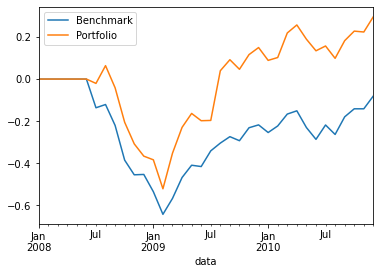

In [42]:
params['model_params']['model_n'] =  'random'

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [43]:
plotAllocation(ah.dropna())

## MeanVariance

No Data collecting

Starting Portfolio Value: 11000.00
Final Portfolio Value: 7079.91


,CAGR,Max_Drawdown,Sharp_Ratio,Value
MeanVariance,-13.643304,71.119399,-0.085525,7079.913433


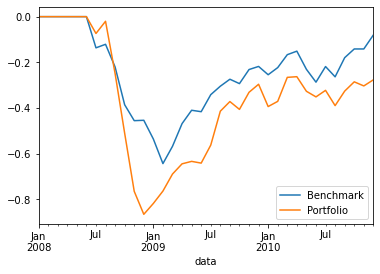

In [44]:
params['model'] = Model()
params['model_params']['model_n'] = 'MeanVariance'


d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [45]:
plotAllocation(ah.dropna())

with data collecting

Starting Portfolio Value: 11000.00
Final Portfolio Value: 8421.32


,CAGR,Max_Drawdown,Sharp_Ratio,Value
MeanVariance_cd,-8.508593,70.456968,-0.031035,8421.323616


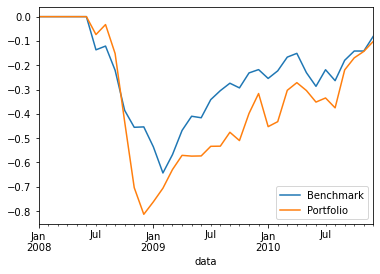

In [46]:
params['model'] = Model()
params['model_params']['model_n'] = 'MeanVariance'
params['model_params']['collectData'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [47]:
plotAllocation(ah.dropna())

## CLA

Starting Portfolio Value: 11000.00
Final Portfolio Value: 9654.27


,CAGR,Max_Drawdown,Sharp_Ratio,Value
CLA,-4.251076,56.747895,0.001079,9654.271888


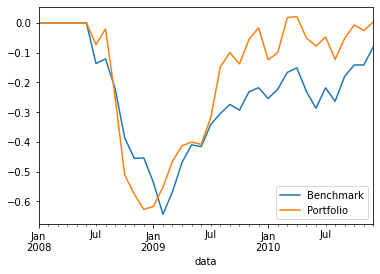

In [48]:
params['model'] = Model()
params['model_params']['model_n'] = 'CLA'
params['model_params']['collectData'] = False

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [49]:
plotAllocation(ah.dropna())

Starting Portfolio Value: 11000.00
Final Portfolio Value: 10504.39


,CAGR,Max_Drawdown,Sharp_Ratio,Value
CLA_cd,-1.522991,56.124467,0.029733,10504.388851


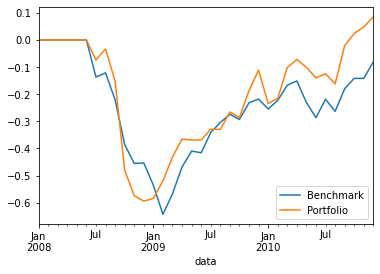

In [50]:
params['model'] = Model()
params['model_params']['model_n'] = 'CLA'
params['model_params']['collectData'] = True
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [51]:
plotAllocation(ah.dropna())

## HRP

Starting Portfolio Value: 11000.00
Final Portfolio Value: 12989.76


,CAGR,Max_Drawdown,Sharp_Ratio,Value
HRP,5.690934,37.98952,0.116519,12989.764539


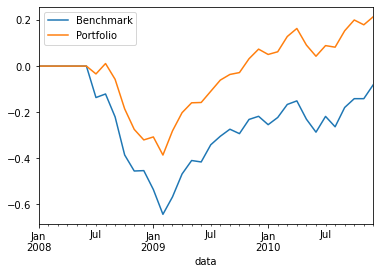

In [52]:
params['model'] = Model()
params['model_params']['model_n'] = 'HRP'
params['model_params']['collectData'] = False

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [53]:
plotAllocation(ah.dropna())

Starting Portfolio Value: 11000.00
Final Portfolio Value: 12838.00


,CAGR,Max_Drawdown,Sharp_Ratio,Value
HRP_cd,5.278268,39.538864,0.107032,12838.004613


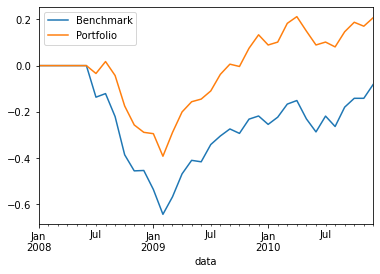

In [54]:
params['model'] = Model()
params['model_params']['model_n'] = 'HRP'
params['model_params']['collectData'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [55]:
plotAllocation(ah.dropna())

## nonconvex

Starting Portfolio Value: 11000.00
Final Portfolio Value: 12847.51


,CAGR,Max_Drawdown,Sharp_Ratio,Value
nonconvex,5.304214,44.390754,0.101062,12847.511327


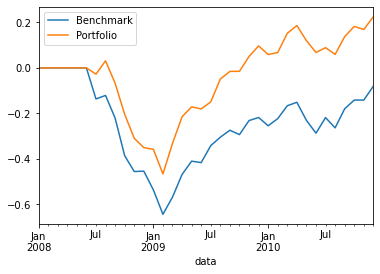

In [56]:
params['model'] = Model()
params['model_params']['model_n'] = 'nonconvex'
params['model_params']['collectData'] = False

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [57]:
plotAllocation(ah.dropna())

Starting Portfolio Value: 11000.00
Final Portfolio Value: 12579.20


,CAGR,Max_Drawdown,Sharp_Ratio,Value
nonconvex_cd,4.566958,45.258051,0.091296,12579.201301


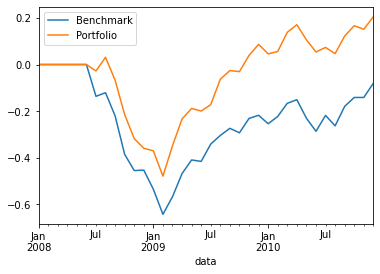

In [58]:
params['model'] = Model()
params['model_params']['model_n'] = 'nonconvex'
params['model_params']['collectData'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [59]:
plotAllocation(ah.dropna())

Starting Portfolio Value: 11000.00
Final Portfolio Value: 11733.28


,CAGR,Max_Drawdown,Sharp_Ratio,Value
equal_weight,2.171521,43.390125,0.060572,11733.275881


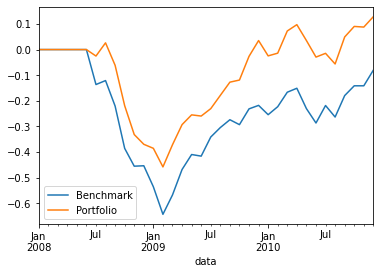

In [69]:
params['model'] = Model()
params['model_params']['model_n'] = 'equal_weight'
params['model_params']['collectData'] = False

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [70]:
params['model'] = Model()
config_cerebro['config_cerebro'] = ['SPY']
d_stat['Benchmark'], d_res['Benchmark'], ah = backtest(config_cerebro, DynRebalance, m_name='Benchmark', plot=False, **params)

Starting Portfolio Value: 11000.00
Final Portfolio Value: 11733.28


In [71]:

stat = getStatistic(d_stat)
stat.to_csv("models_stat_2008_2010.csv")
stat.sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
HRP,5.690934,37.989520,0.116519,12989.764539
HRP_cd,5.278268,39.538864,0.107032,12838.004613
random,6.175282,50.038736,0.101524,13169.406890
nonconvex,5.304214,44.390754,0.101062,12847.511327
nonconvex_cd,4.566958,45.258051,0.091296,12579.201301
equal_weight,2.171521,43.390125,0.060572,11733.275881
Benchmark,2.171521,43.390125,0.060572,11733.275881
CLA_cd,-1.522991,56.124467,0.029733,10504.388851
CLA,-4.251076,56.747895,0.001079,9654.271888
MeanVariance_cd,-8.508593,70.456968,-0.031035,8421.323616


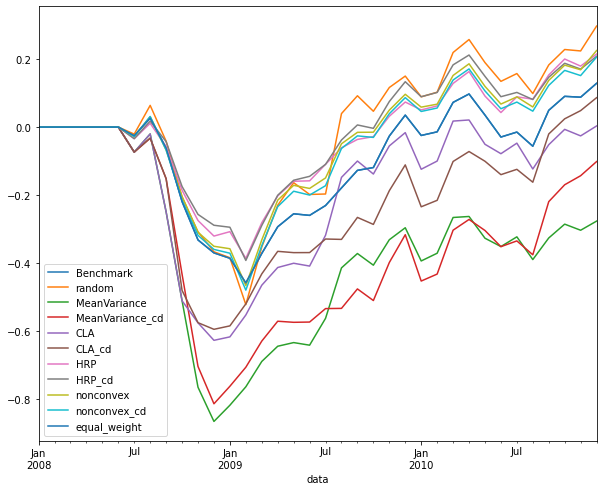

In [72]:
df = plotPorfolioReturns(d_res, None)
df.to_csv('models_drawdown_2008_2010.csv')

# TEST 2011-2017

In [39]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2011, 1, 1),
    'endd'  : datetime(2017, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'CLA',
        'collectData':False,
        'isEmsRet':True,
        'isExpCov':True,
        'isCleanWeight':False,
        'upd_period': 22}
}
d_res = {}
d_stat = {}
config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [40]:
d_stat, d_res, d_ah = executeTest(d_stat, d_res, params, config_cerebro)

MeanVariance
Starting Portfolio Value: 11000.00
Final Portfolio Value: 54911.47
MeanVariance + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 36362.62
CLA
Starting Portfolio Value: 11000.00
Final Portfolio Value: 55353.35
CLA + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 35800.44
HRP
Starting Portfolio Value: 11000.00
Final Portfolio Value: 24653.84
HRP + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 28143.22
noncovex
Starting Portfolio Value: 11000.00
Final Portfolio Value: 28339.89
nonconvex + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 27248.10
random
Starting Portfolio Value: 11000.00
Final Portfolio Value: 29207.49
Benchmark
Starting Portfolio Value: 11000.00
Final Portfolio Value: 22426.67


In [42]:
stat = getStatistic(d_stat)
stat.to_csv("models_stat_2011_2017.csv")
stat.sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
HRP_cd,14.388481,10.764417,0.435486,28143.215483
MeanVariance,25.870180,17.181518,0.397183,54911.473893
CLA,26.014626,17.264400,0.396593,55353.346464
nonconvex_cd,13.860614,15.047415,0.380513,27248.100071
nonconvex,14.502530,15.693264,0.379042,28339.885547
HRP,12.242042,11.825310,0.368727,24653.836870
Benchmark,10.731532,14.964326,0.343768,22426.670000
CLA_cd,18.396374,18.508646,0.342522,35800.444656
MeanVariance_cd,18.660652,19.113128,0.340840,36362.622854
random,14.997701,20.510196,0.328998,29207.494905


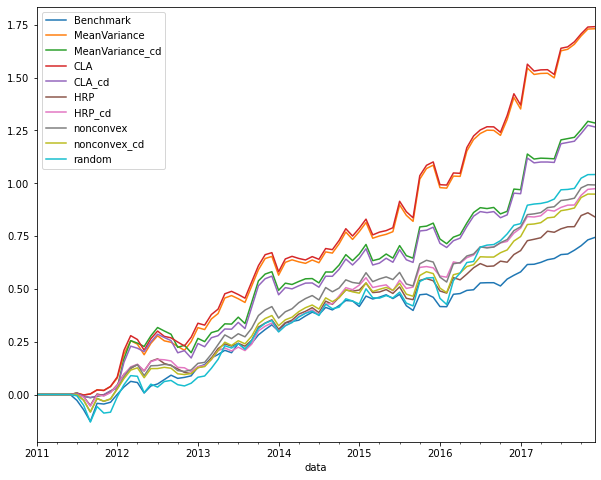

In [43]:
df = plotPorfolioReturns(d_res, None)
df.to_csv('models_drawdown_2011_2017.csv')

# TEST 2018-2021

In [73]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2018, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'CLA',
        'collectData':False,
        'isEmsRet':True,
        'isExpCov':True,
        'isCleanWeight':False,
        'upd_period': 22}
}
d_res = {}
d_stat = {}
config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [74]:
d_stat, d_res, d_ah = executeTest(d_stat, d_res, params, config_cerebro)

MeanVariance
Starting Portfolio Value: 11000.00
Final Portfolio Value: 19432.25
MeanVariance + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 19587.35
CLA
Starting Portfolio Value: 11000.00
Final Portfolio Value: 19266.04
CLA + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 20043.01
HRP
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13913.63
HRP + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 12782.16
noncovex
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13778.34
nonconvex + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13918.87
random
Starting Portfolio Value: 11000.00
Final Portfolio Value: 16906.85
equal_weight
Starting Portfolio Value: 11000.00
Final Portfolio Value: 17943.40
Benchmark
Starting Portfolio Value: 11000.00
Final Portfolio Value: 16384.24


In [75]:
stat = getStatistic(d_stat)
stat.to_csv("models_stat_2018_2021.csv")
stat.sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
CLA_cd,19.902427,25.217390,0.273894,20043.009624
MeanVariance,18.785138,25.788341,0.269670,19432.245047
CLA,18.476867,25.479583,0.268844,19266.042410
MeanVariance_cd,19.071170,25.120084,0.268807,19587.349724
Benchmark,12.809664,28.172682,0.266408,16384.240000
equal_weight,15.954959,29.059167,0.260751,17943.395199
random,13.886321,34.065308,0.235619,16906.845177
HRP,7.367180,29.827330,0.159276,13913.625198
nonconvex_cd,7.379422,31.581170,0.156195,13918.869987
nonconvex,7.050291,32.128620,0.150295,13778.342484


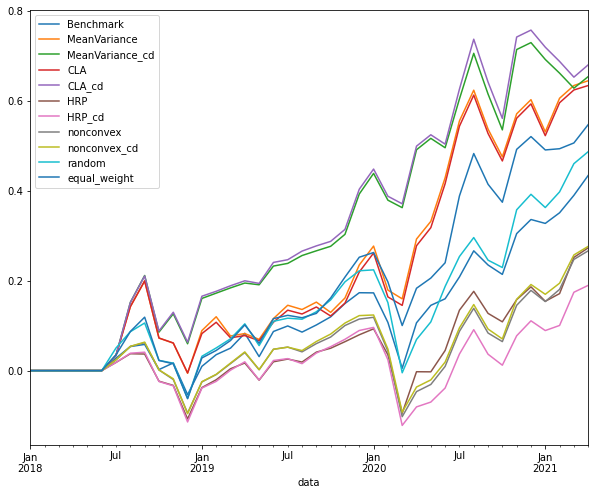

In [76]:
df = plotPorfolioReturns(d_res, None)
df.to_csv('models_drawdown_2018_2021.csv')

# TEST 2012-2016

In [52]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2012, 1, 1),
    'endd'  : datetime(2016, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'CLA',
        'collectData':False,
        'isEmsRet':True,
        'isExpCov':True,
        'isCleanWeight':False,
        'upd_period': 22}
}
d_res = {}
d_stat = {}
config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [53]:
d_stat, d_res, d_ah = executeTest(d_stat, d_res, params, config_cerebro)

MeanVariance
Starting Portfolio Value: 11000.00
Final Portfolio Value: 28206.66
MeanVariance + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 20463.05
CLA
Starting Portfolio Value: 11000.00
Final Portfolio Value: 28264.63
CLA + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 20720.49
HRP
Starting Portfolio Value: 11000.00
Final Portfolio Value: 18125.16
HRP + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 18562.38
noncovex
Starting Portfolio Value: 11000.00
Final Portfolio Value: 19265.91
nonconvex + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 19756.12
random
Starting Portfolio Value: 11000.00
Final Portfolio Value: 21601.21
Benchmark
Starting Portfolio Value: 11000.00
Final Portfolio Value: 18151.82


In [54]:
stat = getStatistic(d_stat)
stat.to_csv("models_stat_2012_2016.csv")
stat.sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
Benchmark,10.554052,11.453894,0.366829,18151.820000
random,14.474896,16.892148,0.363885,21601.206797
nonconvex_cd,12.445650,14.374815,0.355266,19756.120779
nonconvex,11.881112,14.091360,0.343392,19265.912976
CLA,20.809319,25.254031,0.338780,28264.628040
MeanVariance,20.759647,25.322582,0.337322,28206.662026
HRP_cd,11.050487,13.127365,0.335177,18562.383912
HRP,10.521505,11.429037,0.330064,18125.159104
CLA_cd,13.524323,19.400401,0.270505,20720.492765
MeanVariance_cd,13.240358,19.572950,0.265059,20463.045331


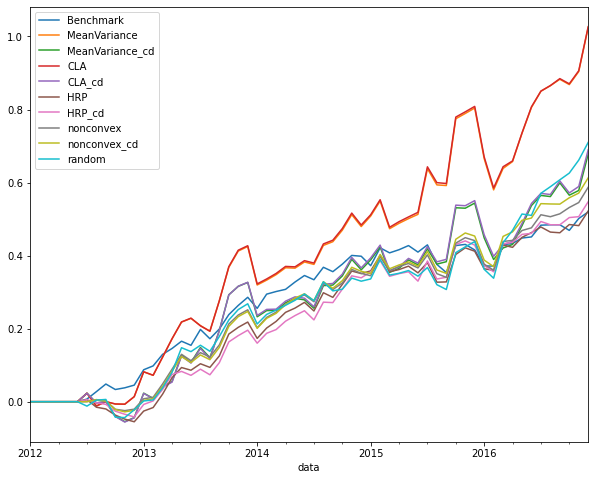

In [55]:
df = plotPorfolioReturns(d_res, None)
df.to_csv('models_drawdown_2012_2016.csv')

# 2016-2021 
SPY, TLT, GLD, IYR

In [77]:
config_cerebro = {
    'assets':['SPY', 'TLT', 'GLD', 'RWO'],
    'benchmark':'SPY',
    'startd': datetime(2016, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'CLA',
        'collectData':False,
        'isEmsRet':True,
        'isExpCov':True,
        'isCleanWeight':False,
        'upd_period': 22}
}
d_res = {}
d_stat = {}
config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [78]:
d_stat, d_res, d_ah = executeTest(d_stat, d_res, params, config_cerebro)

MeanVariance
Starting Portfolio Value: 11000.00
Final Portfolio Value: 12819.44
MeanVariance + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13465.87
CLA
Starting Portfolio Value: 11000.00
Final Portfolio Value: 12924.53
CLA + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13404.21
HRP
Starting Portfolio Value: 11000.00
Final Portfolio Value: 12105.11
HRP + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 12843.28
noncovex
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13158.95
nonconvex + collectData = True
Starting Portfolio Value: 11000.00
Final Portfolio Value: 12728.31
random
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13935.51
equal_weight
Starting Portfolio Value: 11000.00
Final Portfolio Value: 13682.55
Benchmark
Starting Portfolio Value: 11000.00
Final Portfolio Value: 21340.80


In [79]:
stat = getStatistic(d_stat)
stat.to_csv("models_stat_2016_2021_etf.csv")
stat.sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
Benchmark,13.315423,29.510330,0.311167,21340.800000
random,4.562810,15.240367,0.204217,13935.509220
equal_weight,4.202130,16.736368,0.179058,13682.549484
MeanVariance_cd,3.888852,15.371178,0.159503,13465.869926
nonconvex,3.438028,16.736368,0.153497,13158.949486
CLA_cd,3.798957,16.604880,0.152943,13404.210106
HRP_cd,2.965362,15.074231,0.136330,12843.279438
nonconvex_cd,2.790870,16.736368,0.126406,12728.309444
CLA,3.087915,16.104691,0.126061,12924.529865
MeanVariance,2.929284,21.254503,0.111622,12819.439632


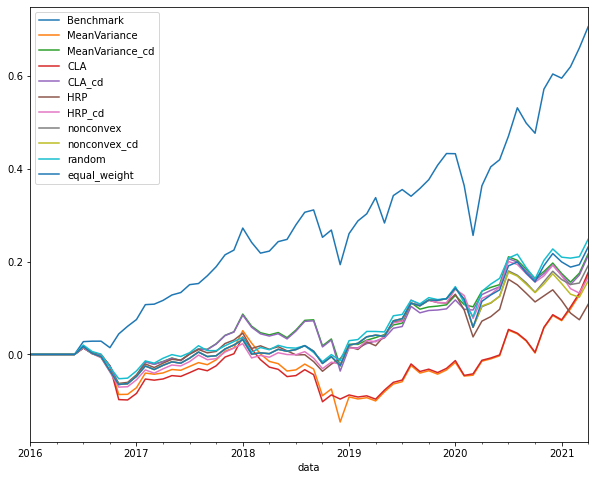

In [80]:
df = plotPorfolioReturns(d_res, None)
df.to_csv('models_drawdown_2016_2021_etf.csv')